In [12]:
# Try to flatten the images first

import os
import numpy as np
from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [17]:
import cv2
import os

# Specify the directory containing images
image_folder = '20241009_image_input_60_1'

# Loop through each file in the directory
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Add other formats if needed
        # Read the image file
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = img > 32
        img = img.astype(np.uint8) * 255
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        print(f"Images shape: {img.shape}")
        # Check if the image is loaded properly
        if img is None:
            print(f"Failed to load {filename}")
            continue

        # Check the number of channels
        if len(img.shape) == 2:
            print(f"{filename}: Grayscale")
        elif len(img.shape) == 3 and img.shape[2] == 3:
            print(f"{filename}: RGB")
            print(f"Images shape: {img.shape}")
        else:
            print(f"{filename}: Unknown format")
        print(img)
        
    break

Images shape: (96, 180)
67451_28_75294_1999-08-30_0.csv.jpeg: Grayscale
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]]


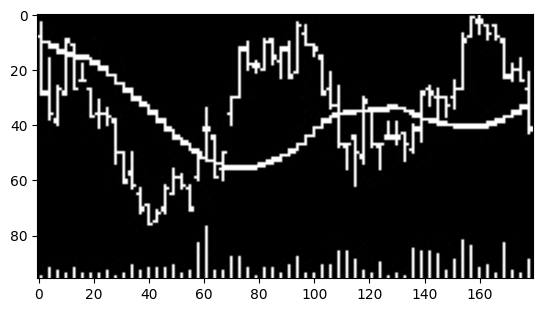

In [14]:
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 255)
    break

In [21]:
import os
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [16]:
# We write a function to convert the images folder to .dat type
def images_to_dat(images_folder, output_file):
    with open(output_file, "wb") as dat_file:
        for filename in sorted([f for f in os.listdir(images_folder) if f != "output.csv"], key = lambda x: int(x.split('_')[0])):
        # for filename in os.listdir(images_folder):
            if filename.endswith(".jpeg"):
            # Read the image file
                img_path = os.path.join(images_folder, filename)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load {filename}")
                    continue 
                img = img > 32
                img = img.astype(np.uint8) * 255
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                img_array = np.array(img)

                # Flatten the image and convert to bytes, for easier storage
                image_bytes = img_array.flatten().tobytes()

                # Write the image data and store that in .dat file
                dat_file.write(image_bytes)

In [17]:
# Use the function
images_to_dat("training_data", "training_data.dat")
images_to_dat("validation_data", "validation_data.dat")

In [18]:
# We then create an array of images
# This is a breakthrough, at least for me, since I cannot do anything to store a large amount like that
# to a list, until I find np.memmap
training_data = []
training_data.append(np.memmap("training_data.dat", dtype = np.uint8, mode = 'r').reshape(
                        (-1, 96, 180))) # since it is 96 x 180 images
training_data = np.concatenate(training_data)
print(training_data.shape)

(86751, 96, 180)


In [15]:
# Similarly, for validation_data
validation_data = []
validation_data.append(np.memmap("validation_data.dat", dtype = np.uint8, mode = 'r').reshape(
    (-1, 96, 180)))
validation_data = np.concatenate(validation_data)
print(validation_data.shape)

(37179, 96, 180)


In [19]:
# For output

def extract_outputs(images_folder):
    outputs = []

    for filename in sorted([f for f in os.listdir(images_folder) if f != "output.csv"], key = lambda x: int(x.split('_')[0])):
        if filename.endswith('.jpeg'):  # Adjust based on file extension
            # Split the filename to extract the output value
            parts = filename.split('_')
            if len(parts) > 4:  # Ensure there are enough parts
                output_value = parts[-1].split('.')[0]  # Get the last part before the extension
                outputs.append(int(output_value))  # Convert to integer and store
            
    return outputs

def save_outputs_to_feather(images_folder, output_file):
    outputs = extract_outputs(images_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'output': outputs})
    
    # Save DataFrame as a Feather file
    df.to_feather(output_file)

In [25]:
save_outputs_to_feather("training_data", "training_outputs.feather")
save_outputs_to_feather("validation_data", "validation_outputs.feather")

In [28]:
training_outputs = pd.concat(pd.read_feather("training_outputs.feather"))
print(f"Training Label Shape: {training_outputs}")
validation_outputs = pd.concat(pd.read_feather("validation_outputs.feather"))
print(f"Validation Label Shape: {validation_outputs}")

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"